<a id="content"></a>
# QF605 Project: Fixed Income Securities
## `Part III`: Convexity Correction
### Team Members:
>Anirban CHAKRABORTY<br>
Boon Heng GOH<br>
Hanley Mahesh RUPAWALLA<br>
Kantapong ARUNADITYA<br>
Maria Vinitha VIJAYANAND<br>
Retwika HAZRA

- [Question 1](#Question1) <= Click
- [Question 2](#Question2)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from scipy.stats import norm
from scipy.optimize import bisect, brentq
from scipy.interpolate import interp1d, CubicSpline
from scipy.integrate import quad
import pprint as pp

import warnings
warnings.filterwarnings("ignore")

In [2]:
SABR_Calibs = pd.read_csv('SABR_Calibs.csv')
Rates_Raw = pd.read_csv('Rates_Raw.csv')

In [3]:
def TimetoYearfrac(x):
    if x[-1].lower() == "m":
        return float(x[:-1])/12
    elif x[-1].lower() == "y":
        return float(x[:-1])
    elif x[-1].lower() == "d":
        return float(x[:-1])/360
    
def Black76Lognormal(F, K, T, r, sigma, opt):
    d1 = (np.log(F/K)+(sigma*sigma/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    if opt == 'Call':
        return F*np.exp(-r*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif opt == 'Put':
        return K*np.exp(-r*T)*norm.cdf(-d2) - F*np.exp(-r*T)*norm.cdf(-d1)
    
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

In [4]:
SABR_Calibs['Expiry'] = SABR_Calibs['Expiry'].apply(TimetoYearfrac)
SABR_Calibs['Tenor'] = SABR_Calibs['Tenor'].apply(TimetoYearfrac)

### Interpolation Functions
> Libor : Linear interpolation <br>OIS : Linear interpolation <br>SABR Parameters : Natural Cubic Spline (2nd derivative at boundary = 0)

In [5]:
Libor_DF = interp1d(Rates_Raw["Tenor"], Rates_Raw["Libor_DF"], fill_value="extrapolate")
OIS_DF = interp1d(Rates_Raw["Tenor"], Rates_Raw["ON_DF"], fill_value="extrapolate")

#Separate Dataframes per parameter to interpolate 
alpha_calib = SABR_Calibs.loc[:,["Expiry", "Tenor", "alpha", "rho", "nu"]].pivot(index='Expiry', columns='Tenor', values='alpha')
rho_calib = SABR_Calibs.loc[:,["Expiry", "Tenor", "alpha", "rho", "nu"]].pivot(index='Expiry', columns='Tenor', values='rho')
nu_calib = SABR_Calibs.loc[:,["Expiry", "Tenor", "alpha", "rho", "nu"]].pivot(index='Expiry', columns='Tenor', values='nu')

def Sabr_Params(expiry, tenor):
    alphacalib = CubicSpline(alpha_calib.index,np.array(alpha_calib.iloc[:,np.where(alpha_calib.columns == tenor)[0][0]]),
                        bc_type='natural')    
    rhocalib = CubicSpline(rho_calib.index,np.array(rho_calib.iloc[:,np.where(rho_calib.columns == tenor)[0][0]]),
                        bc_type='natural')
    nucalib = CubicSpline(nu_calib.index,np.array(nu_calib.iloc[:,np.where(nu_calib.columns == tenor)[0][0]]),
                        bc_type='natural')    
    return alphacalib(expiry), rhocalib(expiry), nucalib(expiry)

Text(0.5, 1.0, 'Nu, Tenor = 10y')

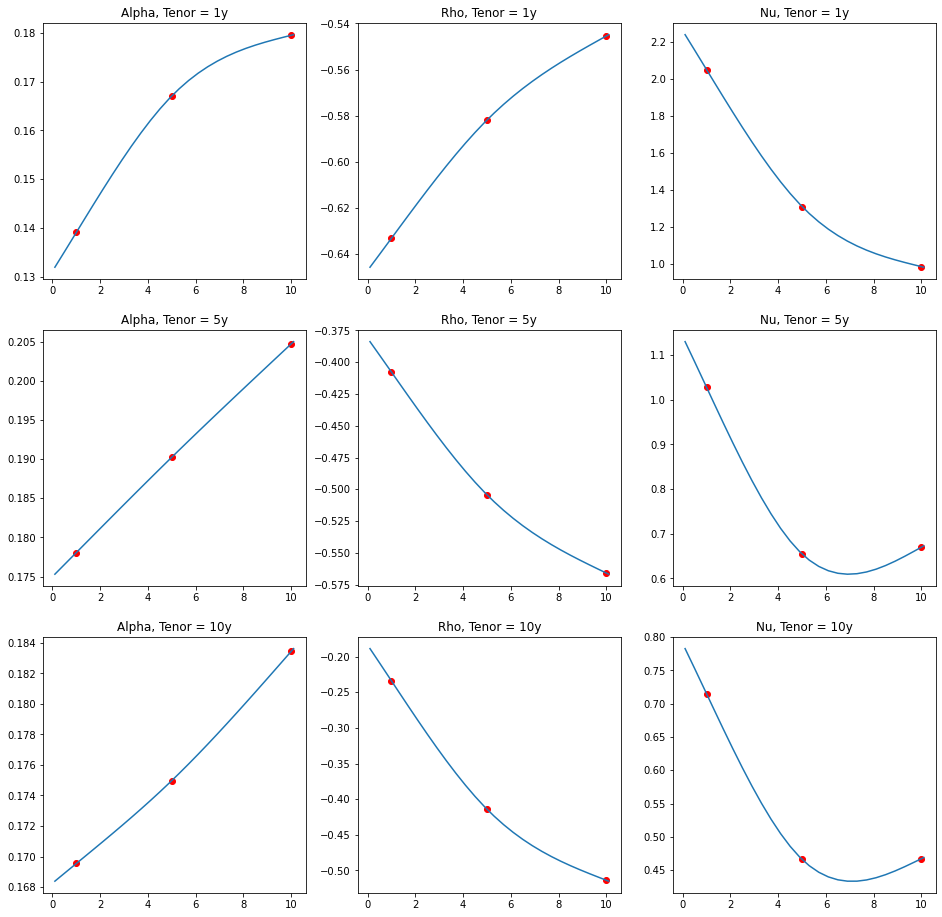

In [6]:
expiries = np.linspace(0.1, 10.1, 26)
fig = plt.figure(figsize=(16, 16))

plt.subplot(331)
plt.plot(expiries, [Sabr_Params(expiry, 1)[0] for expiry in expiries])
plt.scatter(alpha_calib.index, alpha_calib.loc[:,1], color = 'r')
plt.title("Alpha, Tenor = 1y")

plt.subplot(332)
plt.plot(expiries, [Sabr_Params(expiry, 1)[1] for expiry in expiries])
plt.scatter(rho_calib.index, rho_calib.loc[:,1], color = 'r')
plt.title("Rho, Tenor = 1y")

plt.subplot(333)
plt.plot(expiries, [Sabr_Params(expiry, 1)[2] for expiry in expiries])
plt.scatter(nu_calib.index, nu_calib.loc[:,1], color = 'r')
plt.title("Nu, Tenor = 1y")

plt.subplot(334)
plt.plot(expiries, [Sabr_Params(expiry, 5)[0] for expiry in expiries])
plt.scatter(alpha_calib.index, alpha_calib.loc[:,5], color = 'r')
plt.title("Alpha, Tenor = 5y")

plt.subplot(335)
plt.plot(expiries, [Sabr_Params(expiry, 5)[1] for expiry in expiries])
plt.scatter(rho_calib.index, rho_calib.loc[:,5], color = 'r')
plt.title("Rho, Tenor = 5y")

plt.subplot(336)
plt.plot(expiries, [Sabr_Params(expiry, 5)[2] for expiry in expiries])
plt.scatter(nu_calib.index, nu_calib.loc[:,5], color = 'r')
plt.title("Nu, Tenor = 5y")

plt.subplot(337)
plt.plot(expiries, [Sabr_Params(expiry, 10)[0] for expiry in expiries])
plt.scatter(alpha_calib.index, alpha_calib.loc[:,10], color = 'r')
plt.title("Alpha, Tenor = 10y")

plt.subplot(338)
plt.plot(expiries, [Sabr_Params(expiry, 10)[1] for expiry in expiries])
plt.scatter(rho_calib.index, rho_calib.loc[:,10], color = 'r')
plt.title("Rho, Tenor = 10y")

plt.subplot(339)
plt.plot(expiries, [Sabr_Params(expiry, 10)[2] for expiry in expiries])
plt.scatter(nu_calib.index, nu_calib.loc[:,10], color = 'r')
plt.title("Nu, Tenor = 10y")

### $ Forward\ LIBOR = L(T_{i-1} , T_{i}) = \frac{1}{Delta} * \frac{D_0(0, T_{i-1}) - D_0(0, T_i)}{D_0(0, T_i)}$
### $ Forward\ Swap\ Rate = \frac {Floating\ Leg}{Fixed\ Leg} = \frac{\sum_{n=i}^{N} D_0(0, T_i) * L(T_i, T_{i-1}) * delta}{\sum_{n=i}^{N} D_0(0,T_i)* delta} $

In [7]:
#forward libor rate
def FwdRate(D_Small,D_Large,delta):
    return (1/delta)*((D_Small-D_Large)/D_Large)

#forward swap rate
def FwdSwapRate(start, tenor, delta):   
    Numerator = sum([OIS_DF(start + i*delta)*FwdRate(Libor_DF(start + i*delta-delta),Libor_DF(start + i*delta),delta)*delta 
                     for i in range(1,int(tenor/delta)+1)])
    Denominator = sum([OIS_DF(start + i*delta)*delta for i in range(1,int(tenor/delta)+1)])
    return Numerator/Denominator

In [8]:
def IRR(Tenor, Delta, K):
    return sum([Delta*(1 + K* Delta)**(-i) for i in np.arange(1, Tenor/Delta +1)])

def IRR_prime(Tenor, Delta, K):
    return sum([(-i)*(Delta**2)*(1 + K* Delta)**(-i-1) for i in np.arange(1, Tenor/Delta +1)])

def IRR_doubleprime(Tenor, Delta, K):
    return sum([(-i)*(-i-1)*(Delta**3)*(1 + K* Delta)**(-i-2) for i in np.arange(1, Tenor/Delta +1)])

### $h''(K) = \frac{-IRR''(K) * K - 2 * IRR'(K)}{IRR(K)^2} + \frac{2 * IRR'(K)^2 * K}{IRR(K)^3}$

In [9]:
def h_doubleprime(Tenor, Delta, K):
    IRR_0 = IRR(Tenor, Delta, K)
    IRR_1 = IRR_prime(Tenor, Delta, K)
    IRR_2 = IRR_doubleprime(Tenor, Delta, K) 
    return (-IRR_2*K - 2*IRR_1) / (IRR_0**2) + 2*(IRR_1**2)*K/(IRR_0**3)

### $ CMS\ Rate = E^T [S_{n,N}(T)]= g(F) + \frac{1}{D(0,T)} \left[\int_0^F h''(K)V^{rec}(K)dK + \int_F^\infty h''(K)V^{pay}(K)dK\right] $

In [10]:
def integrand(F, K, T, r, sigma, tenor, delta, opt):
    irr = IRR(tenor, delta, F)
    h_doubleprimek = h_doubleprime(tenor, delta, K)
    return h_doubleprimek*Black76Lognormal(F, K, T, r, sigma, opt)


def CMSRate(expiry, tenor, delta):
    F       = FwdSwapRate(expiry, tenor, delta)
    alpha   = Sabr_Params(expiry, tenor)[0]
    rho     = Sabr_Params(expiry, tenor)[1]
    nu      = Sabr_Params(expiry, tenor)[2]
    VRec     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Put'), 0, F)
    VPay     = quad(lambda x:integrand(F,x,expiry,0,
                                      SABR(F,x,expiry,alpha,0.9,rho,nu),
                                      tenor, delta, 'Call'), F, 0.1) 
    return F + VRec[0] + VPay[0]

<a id="Question1"></a>
### 1. Using the SABR model calibrated in the previous question, value the following constant maturity swap (CMS) products:

- PV of a leg receiving CMS10y semi-annually over the next 5 years
- PV of a leg receiving CMS2y quarterly over the next 10 years

In [11]:
def PV_CMS(tenor, cms_period, delta):
    n = int(cms_period/delta)
    return sum([OIS_DF(i*delta)*delta*CMSRate(i*delta,tenor,delta) for i in range(1,n+1)])

In [12]:
cms_period = 5
tenor = 10
delta = 0.5

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS10y semi-annually over the next 5 years = ',PV )

PV of a leg receiving CMS10y semi-annually over the next 5 years =  0.20205204826488532


In [13]:
cms_period = 10
tenor = 2
delta = 0.25

PV = PV_CMS(tenor, cms_period, delta)
print('PV of a leg receiving CMS2y quarterly over the next 10 years = ',PV )

PV of a leg receiving CMS2y quarterly over the next 10 years =  0.3820711925166146


[Back to top](#content)

<a id="Question2"></a>
### 2. Compare the forward swap rates with the CMS rate:

- 1y  x 1y, 1y  x 2y,  1y x 3y, 1y  x 5y, 1y  x 10y
- 5y  x 1y, 5y  x 2y,  5y x 3y, 5y  x 5y, 5y  x 10y
- 10y x 1y, 10y x 2y, 10y x 3y, 10y x 5y, 10y x 10y

In [14]:
Comparison = SABR_Calibs.iloc[:,0:2].copy()
Comparison["Fwd Swap Rate"] = np.nan
Comparison["CMS Rate"] = np.nan

for i in range(0,len(Comparison)):
    Comparison["Fwd Swap Rate"][i] = FwdSwapRate(Comparison["Expiry"][i], Comparison["Tenor"][i], delta)
    Comparison["CMS Rate"][i] = CMSRate(Comparison["Expiry"][i],Comparison["Tenor"][i],0.5)
Comparison.to_csv('Comparison_Tbl.csv',sep=',', index = False)

Text(0.5, 1.0, 'Expiry = 1y')

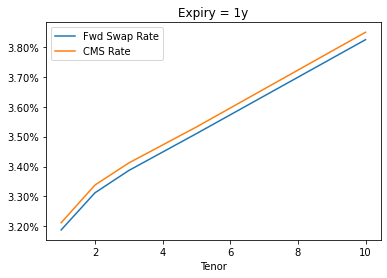

In [15]:
ax = Comparison.iloc[np.where(Comparison['Expiry']==1)[0], 1:].set_index('Tenor', drop = True).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title('Expiry = 1y')

Text(0.5, 1.0, 'Expiry = 5y')

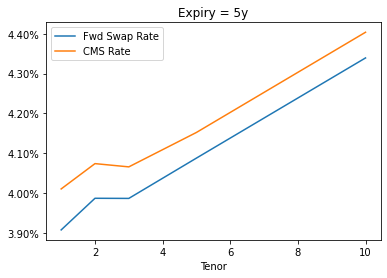

In [16]:
ax = Comparison.iloc[np.where(Comparison['Expiry']==5)[0], 1:].set_index('Tenor', drop = True).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title('Expiry = 5y')

Text(0.5, 1.0, 'Expiry = 10y')

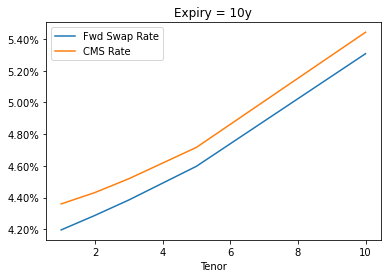

In [17]:
ax = Comparison.iloc[np.where(Comparison['Expiry']==10)[0], 1:].set_index('Tenor', drop = True).plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_title('Expiry = 10y')

In [18]:
Comparison["Expiry"] = pd.read_csv('SABR_Calibs.csv').iloc[:,0]
Comparison["Tenor"] = pd.read_csv('SABR_Calibs.csv').iloc[:,1]
Comparison["Fwd Swap Rate"] = Comparison[["Fwd Swap Rate"]].applymap(lambda x: "{0:.2f}%".format(x*100))
Comparison["CMS Rate"] = Comparison[["CMS Rate"]].applymap(lambda x: "{0:.2f}%".format(x*100))

In [19]:
pp.pprint(Comparison)

   Expiry Tenor Fwd Swap Rate CMS Rate
0      1Y    1Y         3.19%    3.21%
1      1Y    2Y         3.31%    3.34%
2      1Y    3Y         3.39%    3.41%
3      1Y    5Y         3.51%    3.53%
4      1Y   10Y         3.82%    3.85%
5      5Y    1Y         3.91%    4.01%
6      5Y    2Y         3.99%    4.07%
7      5Y    3Y         3.99%    4.07%
8      5Y    5Y         4.09%    4.15%
9      5Y   10Y         4.34%    4.40%
10    10Y    1Y         4.20%    4.36%
11    10Y    2Y         4.29%    4.43%
12    10Y    3Y         4.38%    4.52%
13    10Y    5Y         4.60%    4.72%
14    10Y   10Y         5.31%    5.44%


[Back to top](#content)